In [45]:
import time
import sys
import lasagne
import theano
import os
import argparse
from collections import defaultdict
from lasagne_utils import save_model, store_in_log, load_model, load_log, \
                          ExponentialUniformInit, non_flattening_dense, get_layer_output_fn
import theano.tensor as T
import numpy as np

from refrac_plstm import RefracPLSTMLayer
from rrnn_beta import RRNNLayer

from matplotlib import pyplot as plt
%matplotlib inline

In [46]:
num_units = 5

# Create symbolic vars
input_var       = T.ftensor3('my_input_var')
mask_var        = T.fmatrix('my_mask')
target_var      = T.ivector('my_targets')
time_var        = T.fmatrix('my_timevar')

# (batch size, max sequence length, number of features)
l_in = lasagne.layers.InputLayer(shape=(None, None, 1), input_var=input_var)
# Mask as matrices of dimensionality (N_BATCH, MAX_LENGTH)
l_mask = lasagne.layers.InputLayer(shape=(None, None), input_var=mask_var)
# Time as matrices of dimensionality (N_BATCH, MAX_LENGTH)
l_t = lasagne.layers.InputLayer(shape=(None, None), input_var=time_var)
# Define the RNN
l_refrac = RRNNLayer(l_in, time_input=l_t, num_units=num_units, mask_input=l_mask,
                learn_time_params=[False])
# Get generic params
batch_size, seq_len, _ = input_var.shape
# Get inputs
fn_inputs = [input_var, mask_var, time_var]
all_outs = []
for layer in lasagne.layers.get_all_layers(l_refrac):
    all_outs.append(lasagne.layers.get_output(layer, deterministic=True))

all_outs.append(l_refrac.refrac_out)
print('Compiling...')
get_refrac_outs = theano.function(fn_inputs, all_outs)
print('Done.')

# Set the periods to be steps
l_refrac.period_timegate.set_value(np.arange(num_units, dtype='float32')*5.)

Learnableness: [False]
Using true off for testing.
Compiling...
Done.


Generating Data.


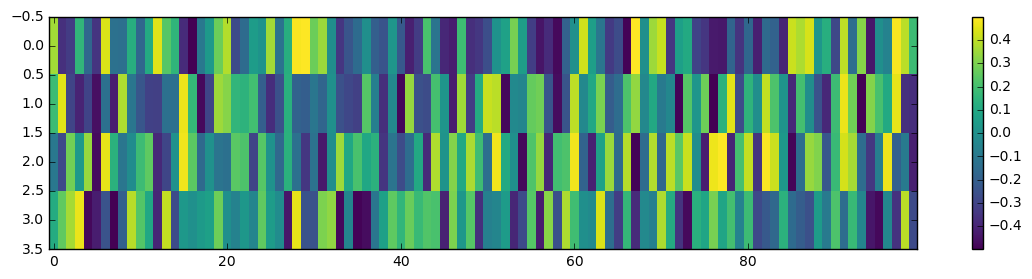

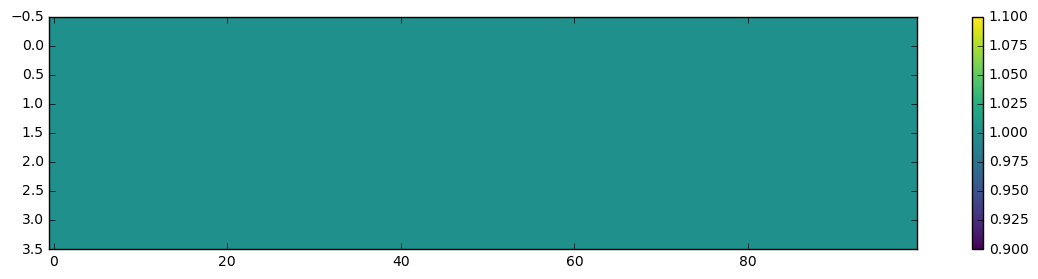

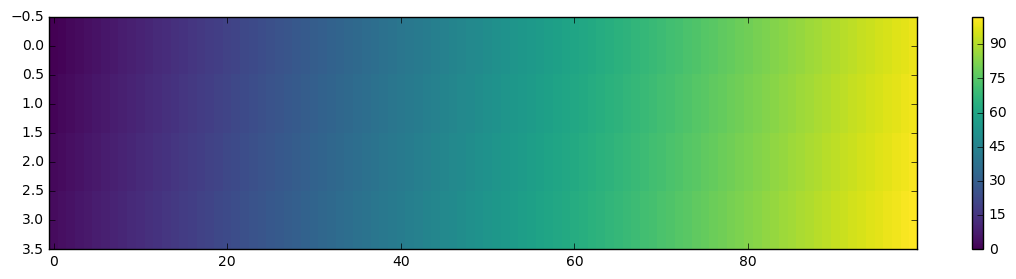

In [47]:
num_timesteps = 100
batch_size = 4

print('Generating Data.')
t_in = np.zeros( (batch_size, num_timesteps), dtype='float32' )
mask_in = np.zeros( (batch_size, num_timesteps), dtype='float32' )
inp_in = np.zeros( (batch_size, num_timesteps, 1), dtype='float32' )
for idx in range(batch_size):
    t_in[idx, :] = np.arange(num_timesteps, dtype='float32') + idx
    mask_in[idx, :] = 1.
    inp_in[idx, :, :] = np.random.random( (num_timesteps, 1) ) - 0.5

plt.figure(figsize=(14,3))
plt.imshow(np.squeeze(inp_in), interpolation='nearest', aspect='auto', cmap='viridis')
plt.colorbar()
plt.figure(figsize=(14,3))
plt.imshow(mask_in, interpolation='nearest', aspect='auto', cmap='viridis')
plt.colorbar()
plt.figure(figsize=(14,3))
plt.imshow(t_in, interpolation='nearest', aspect='auto', cmap='viridis')
plt.colorbar()

In [48]:
print('Producing output...')
outs = get_refrac_outs(inp_in, mask_in, t_in)
print('Calculated.')

Producing output...
Calculated.


(4, 100, 1)
(4, 100)
(4, 100)
(4, 100, 5)
(4, 100, 5)


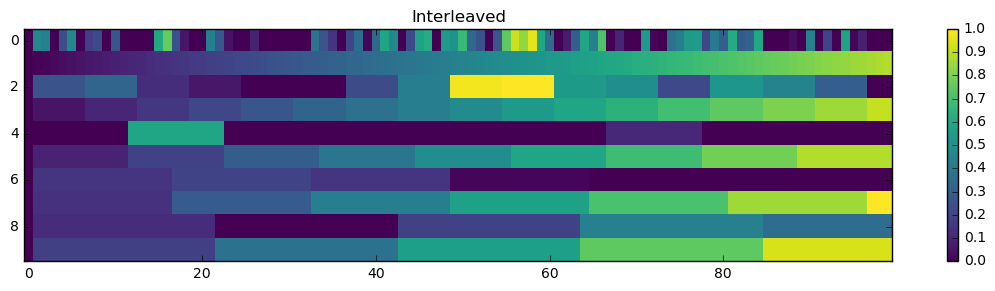

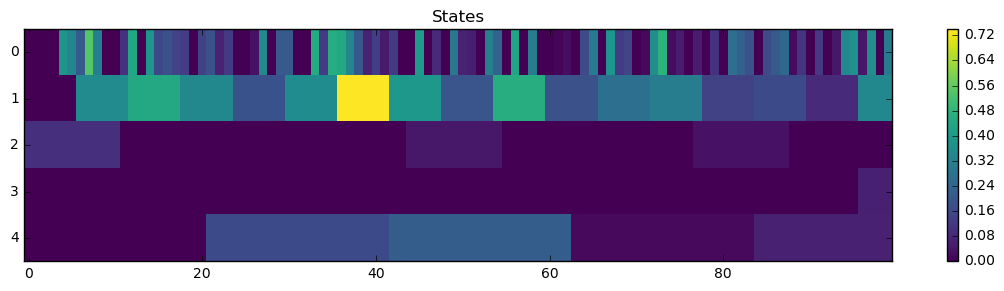

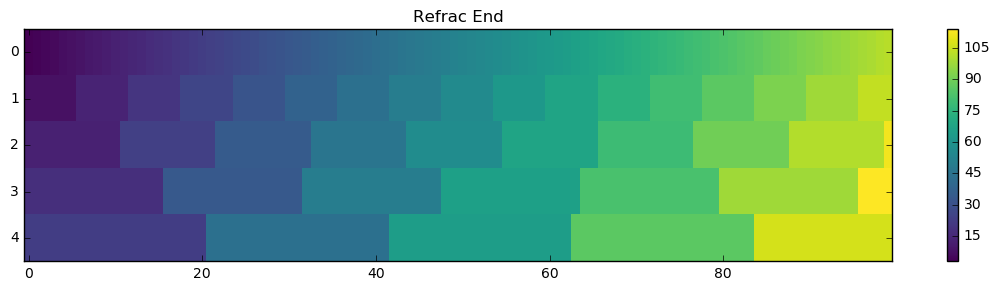

In [49]:
for outp in outs:
    print(outp.shape)

def interleave_rows(a, b, rescale=True):
    c = np.zeros((a.shape[0]+b.shape[0], a.shape[1]), dtype=a.dtype)
    c[0::2] = (a-np.min(a))/(np.max(a)-np.min(a))
    c[1::2] = (b-np.min(b))/(np.max(b)-np.min(b))
    return c


plt.figure(figsize=(14,3))        
plt.imshow(interleave_rows(outs[-2][0].T, outs[-1][0].T), interpolation='nearest', aspect='auto', cmap='viridis')
plt.title('Interleaved')
plt.colorbar()

plt.figure(figsize=(14,3))        
plt.imshow(outs[-2][3].T, interpolation='nearest', aspect='auto', cmap='viridis')
plt.title('States')
plt.colorbar()

plt.figure(figsize=(14,3))        
plt.imshow(outs[-1][3].T, interpolation='nearest', aspect='auto', cmap='viridis')
plt.title('Refrac End')
plt.colorbar()

In [29]:
from theano import pp
pp(T.grad(T.sum(lasagne.layers.get_output(l_refrac, deterministic=True)), 
          l_refrac.period_timegate))

Using true off for testing.


"GpuFromHost(Constant{-1}[for{cpu,grad_of_scan_fn}((Constant{0}[Shape(for{cpu,scan_fn}(minimum(minimum(Constant{0}[Shape(Constant{0}[int64:])], Constant{0}[Shape(Constant{0}[int64:])]), Constant{0}[Shape(Constant{0}[int64:])]), ScalarFromTensor(minimum(minimum(Constant{0}[Shape(Constant{0}[int64:])], Constant{0}[Shape(Constant{0}[int64:])]), Constant{0}[Shape(Constant{0}[int64:])]))[:int64], ScalarFromTensor(minimum(minimum(Constant{0}[Shape(Constant{0}[int64:])], Constant{0}[Shape(Constant{0}[int64:])]), Constant{0}[Shape(Constant{0}[int64:])]))[:int64], ScalarFromTensor(minimum(minimum(Constant{0}[Shape(Constant{0}[int64:])], Constant{0}[Shape(Constant{0}[int64:])]), Constant{0}[Shape(Constant{0}[int64:])]))[:int64], IncSubtensor{Set;:int64:}(AllocEmpty{dtype='float32'}((minimum(minimum(Constant{0}[Shape(Constant{0}[int64:])], Constant{0}[Shape(Constant{0}[int64:])]), Constant{0}[Shape(Constant{0}[int64:])]) + Constant{0}[Shape(Rebroadcast{0}((alloc(TensorConstant{1.0}, Constant{1}[S